<a href="https://colab.research.google.com/github/hariszaf/metabolic_toy_model/blob/haris-comp-methods/Antony2025/computationalMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computational Methods Applied To Genome-Scale Metabolic Models**

## **Prepare your environment**

### Gurobi and cobra

To run this note, you need COBRApy and gurobi. [See the notebook on preparing your environment for a more detailed explanation](preparingYourEnvironment.ipynb)

In [ ]:
import os
def create_gurobi_license(WLSACCESSID, WLSSECRET, LICENSEID):
    license_content = (
        "# Gurobi WLS license file\n"
        "# Your credentials are private and should not be shared or copied to public repositories.\n"
        "# Visit https://license.gurobi.com/manager/doc/overview for more information.\n"
        f"WLSACCESSID={WLSACCESSID}\n"
        f"WLSSECRET={WLSSECRET}\n"
        f"LICENSEID={LICENSEID}"
    )
    with open("/content/licenses/gurobi.lic", "w") as f:
        f.write(license_content)
    print("License file created at /content/licenses/gurobi.lic")

# Create directory for the license
os.makedirs("/content/licenses", exist_ok=True)

# Generate the license file
create_gurobi_license(WLSACCESSID, WLSSECRET, LICENSEID)

#add to path
os.environ['GRB_LICENSE_FILE'] = '/content/licenses/gurobi.lic'

In [ ]:
!pip install gurobipy
!pip install cobra

In [ ]:
import gurobipy
from gurobipy import Model
model = Model("test")
print("Gurobi is working!", "\U0001F600")

#install COBRApy
import cobra
from cobra.io import load_model
model = load_model("textbook")
solution = model.optimize()
print(f"flux balance analysis solution is {solution.objective_value}")
print("COBRApy is working", "\U0001F600")

### **Get path with files we will use**

> **NOTE** 
> 
> Run the following two chunks, **only** in case you are working on Google Colab. 

In [ ]:
!git clone https://github.com/hariszaf/metabolic_toy_model.git

In [ ]:
import os
os.chdir("/content/metabolic_toy_model/Antony2025")

### Access some extra scripts

In [1]:
import numpy as np 
import sys, os

sys.path.append( os.path.dirname(os.getcwd()) )
from scripts.intro import FluxBalanceAnalysis, constrain_plane_in_3D, samples_in_constraint_3D, plot_prod_env_3D

## Background on constraint-based analysis 

### What is LP?

> **DEFINITION**
> 
> **Linear programming (LP**), also called **linear optimization**, is a method to achieve the *best* outcome (such as *maximum* profit or *lowest* cost) in a mathematical
> *model* whose ***requirements*** and ***objective*** are represented by **linear relationships**. 
> 
> Linear programming is a special case of mathematical programming (also known as mathematical optimization).
> 
> From the [LP wiki lemma](https://en.wikipedia.org/wiki/Linear_programming): 


![starwars](https://img.filmsactu.net/datas/films/s/t/star-wars-episode-ix/n/star-wars-episode-ix-gif-5ccb96a1c2f0a.gif)

Let's try to define the above in mathematical terms and then go through those! 

Linear programs are problems that can be expressed in standard form as:


\begin{array}{l r}
    \text{(Find a vector in which you are interested in, e.g. fluxes of a set of reactions)} & \mathrm{x} \\
    \text{(that maximizes a certain objective function, e.g. the ATP production)} & c^T \mathrm{x} \\
    \text{(subject to, meaning that it respects a set of constraints)} & A\mathrm{x} \leq b \\
    \text{(and some extra constraints!)} & \mathrm{x} \geq 0
\end{array}


The above formula is the **generic form** of a liner program. 
To better understand it, we will map the quantities of the system with their metabolic model-oriented ones. 

Consider a very short pathway that consists of only four reactions.

![s_example](../files/figs/s_examples.png)

> Hint :warning:
>
> As you can see, metabolite and reaction names in this case do not have the `rxn` and `cpd` prefixes. 
> This is because they come from the [BiGG](http://bigg.ucsd.edu) namespace and not from the one of ModelSEED that we use in this workshop's models.

In this figure, you can see the basic concept of metabolic modeling analysis. 
The network on the left is just a representation of what we are actually using, a list of enzymes (RNDR2, GKI, PYK etc.)! 

The **stoichiometry** of each of those reactions is **always the same, across all different taxa**! 

Therefore, from a list of enzymes, we can build the $S$ table on the right, where each row is a metabolite and its column is a reaction, with the values on the table per column, represent the stoichiometry of the corresponding reaction!


:red_circle: This stoichiometric matrix ($S$) corresponds to the $A$ matrix on the generic form of the LP. 

:red_circle: Our constraints $v_{lb}$ and $v_{ub}$ correspond to the $b$ vector on the generic form of the LP. 

:red_circle: The quantity to be determined ($\mathrm{x}$) in our case would be the flux vector, ie., a $v$ that supports the optimal value. 

:red_circle: The objective function $c^Tx$ in the generic formula, is nothing but our flux vector ($v$) when multiplied with the objective coefficients vector ($c$). 

> **NOTE**
> 
> :exclamation: If you look a bit closer, you may notice that in our case, we have both lower and upper bounds, 
> while in the generic formula we see only a part for having the product between the matrix and the quantity to be determined.
>
> Can you think how this would be addressed ? 

In [2]:
# Stoichiometric matrix for a single reaction: A -> B, constraints are -v1 + v2 = 0
S = np.array([[1, -1]])

# Bounds: flux 1 between 0 and 5, flux 2 between 0 and 5
bounds = [(-2, 10), (-4, 5)]

# Objective: Maximize v2 (e.g., production of B)
objective = np.array([0, 1])

# Create the FBA instance
fba = FluxBalanceAnalysis(S, bounds, objective)

# Run optimization
result = fba.optimize()
print("Optimization Result:", result)

Optimization Result:         message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -5.0
              x: [ 5.000e+00  5.000e+00]
            nit: 0
          lower:  residual: [ 7.000e+00  9.000e+00]
                 marginals: [ 0.000e+00  0.000e+00]
          upper:  residual: [ 5.000e+00  0.000e+00]
                 marginals: [ 0.000e+00 -1.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-0.000e+00]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0


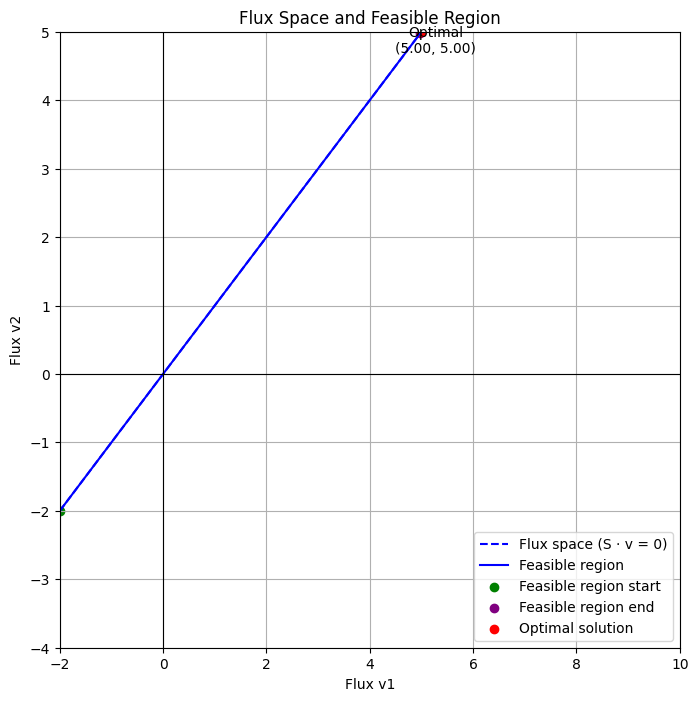

In [41]:
# Visualize the geometry
fba.visualize_geometry()

> :question: **Task!**
>
> Who can describe us how the PYK reaction of the network is represented on the $S$ table?  


Yet, what we are interested in are the fluxes, but what is it actually a flux ? 


(
    for more visual and conceptual components, you may travel on the [*Journey of a Metabolite*](https://iwasa.biochem.utah.edu/metabolism/chapter2.html) 
)


<iframe src="https://player.vimeo.com/video/542375960" width="840" height="560" frameborder="0" allowfullscreen></iframe>

> **Definition**
>
> Metabolic **flux** is amount of a metabolite processed by one or more catalytic steps per unit of time, and it is normalized by cellular abundance (e.g. gram dry weight) ([Stephanopoulos et al., 1998](https://www.sciencedirect.com/book/9780126662603/metabolic-engineering)).

Thus, there is a very simple relationship between concentrations and fluxes:

 $$ \frac{dx}{dt}= Sv(x) $$

where:
- $x$ the concentration vector
- $S$ the stoichiometric matrix of your network, and 
- $v$ the fluxes of your species at a certain time point.

Assuming our system lives in a steady state, meaning the **concentrations** of metabolites remain **constant** over time, meaning that the **rates of production and consumption** of each metabolite are **balanced**.


### What is a constraint ? 

We call a ***constraint*** a mathematical condition that limits the feasible solutions of an optimization problem. Constraints define the relationships between decision variables and ensure that the solution satisfies certain conditions.

In metabolic modeling, there are several types of constraints representing various biological factors. 

Constraints may be denoted either as:

- **Equality constraints:**
  e.g. $x_1 + x_2 = 10$

- **Inequality constraints:**
  e.g. $2x_1 - 4x_3 \leq 30$

- **Bound constraints**:
  e.g. $0 \leq x_1 \leq 20$


Indicatively, we may note: 
    
- **Mass Balance Constraints (Steady-State Constraint)**
  Core of our LP. 
  Ensures that metabolite concentrations remain constant (no accumulation or depletion).

- **Thermodynamic Constraints**

  Impose reaction directionality (some reactions are irreversible).
  Based on Gibbs free energy:

  $ΔG=ΔG^0 + RTln(Q)$


- **Enzyme Capacity Constraints**
  Limits fluxes based on enzyme abundance or activity

- **Nutrient Uptake Constraints**
  exchange reactions

- **Resource allocation**

$$\sum_i \frac{v_i}{k_{\text{cat}, i} E_i} \leq E_{\text{total}}$$

where:

$v_i$ = reaction flux, 
$k_{cat,i}$ = enzyme turnover number,
$E_i​$  = enzyme concentration,
$E_{total}$ = total enzyme budget

- **Energy constraints (ATP)**

  ATP maintenance requirements for cellular functions 

- **Coupling constraints**

 Links fluxes of related reactions due to enzyme co-regulation or co-factor dependencies.
 e.g. $v_1 = kv_2$
​


In [4]:
samples_in_constraint_3D(
    r1_bounds = [5, 10],
    r2_bounds = [-2, 10],
    r3_bounds = [0,  40],
    r3_relationship = [-1, -1]
)
# In case you are running this locally and you get an error, 
# try to prvide a renderer on the function
# e.g samples_in_constraint_3D(r1_bounds, r2_bounds, r3_bounds, renderer="browser")

Opening in existing browser session.


## Constraint-based methods for metabolic modeling analysis 

### Flux Balance Analysis

In [6]:
import cobra
ecoli = cobra.io.read_sbml_model("files/models/e_coli_core.xml")

Set parameter Username
Set parameter LicenseID to value 2634947
Academic license - for non-commercial use only - expires 2026-03-11


In [17]:
ecoli

Name,e_coli_core
Memory address,741baa214310
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


In [7]:
sol_fba = ecoli.optimize()

In [9]:
sum_fba = ecoli.summary()

In [10]:
sum_fba

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


> **TASK**
>
> 1. What is the limiting factor for the growth of the e_coli_core model ? 
>
> 2. Go on and tell us what would you do to achieve a higher growth in terms of considering the constraints on your model 

Summary can be rather useful as shown above for the model overall. 

`cobra` supports summaries per metabolite and reaction as well, for example:

In [13]:
ecoli.metabolites.atp_c.summary()

Percent,Flux,Reaction,Definition
66.58%,45.51,ATPS4r,adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c
23.44%,16.02,PGK,3pg_c + atp_c <=> 13dpg_c + adp_c
2.57%,1.758,PYK,adp_c + h_c + pep_c --> atp_c + pyr_c
7.41%,5.064,SUCOAS,atp_c + coa_c + succ_c <=> adp_c + pi_c + succoa_c
Percent,Flux,Reaction,Definition
12.27%,-8.39,ATPM,atp_c + h2o_c --> adp_c + h_c + pi_c
76.46%,-52.27,BIOMASS_Ecoli_core_w_GAM,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
0.33%,-0.2235,GLNS,atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c
10.94%,-7.477,PFK,atp_c + f6p_c --> adp_c + fdp_c + h_c


### Gene Knockouts

In [18]:
ecoli.genes[0]

Gene identifier,b1241
Name,adhE
Memory address,0x741b7ad37b90
Functional,True
In 2 reaction(s),"ALCD2x, ACALD"


You would get the same by asking the specific gene id.

In [19]:
ecoli.genes.b1241

Gene identifier,b1241
Name,adhE
Memory address,0x741b7ad37b90
Functional,True
In 2 reaction(s),"ALCD2x, ACALD"


A rather common and among the first tasks in metabolic modeling was to test how your species would react it they would lose a gene!
This can be easily rephrased as what would happen if a reaction of interest, was not allowed to have any flux at all.

So let us knockout the Aconitase reaction and see what happens!


In [21]:
ecoli.reactions.ACONTa.knock_out()

In [24]:

ecoli.reactions.ACONTa

Reaction identifier,ACONTa
Name,"Aconitase (half-reaction A, Citrate hydro-lyase)"
Memory address,0x741b7ab79510
Stoichiometry,cit_c --> acon_C_c + h2o_c Citrate --> Cis-Aconitate + H2O H2O
GPR,b0118 or b1276
Lower bound,0
Upper bound,0


As you can see, the reaction is still part of my model but both its bounds now are set to 0. 

To check how this affected our model, let's just optimize (FBA) the model again.

In [23]:
ecoli.optimize()

,fluxes,reduced_costs
PFK,4.195,0.0
PFL,0.000,0.0
PGI,4.195,0.0
PGK,-8.390,-0.0
PGL,0.000,0.0
...,...,...
NADH16,0.000,0.0
NADTRHD,0.000,0.0
NH4t,0.000,0.0
O2t,0.000,0.0


Ooops! The e_coli_core model now is not able to grow! 
You see though that the fluxes of other reactions are not always 0. 

In [25]:
ecoli.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,0.9322,6,100.00%
o2_e,EX_o2_e,1.864,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-1.864,2,66.67%
co2_e,EX_co2_e,-1.864,1,33.33%
h2o_e,EX_h2o_e,-1.864,0,0.00%
h_e,EX_h_e,-1.864,0,0.00%


> **TASK**
>
> Compare the summaries of the initial model and of the one with the Aconitase reaction knocked out.

`cobra` allows you to perform all single gene deletions on a model as well as double deletions! 

In [31]:
from cobra.flux_analysis import single_gene_deletion
deletion_results = single_gene_deletion(ecoli)
deletion_results["growth"]

0.0

In [32]:
max(deletion_results["growth"])

0.0

The e_coli_core model is a toy example where every reaction is required for the growth of the model. 

> **TASK**
>
> 1. Using a gapfilled model of yours, try to get your gene deletions and tell us what percentage of their genes can be removed without your model lose its ability to grow. 
> 2. What if you would try the `single_reaction_deletion` function of `cobra`? Would that be any different ? 
> 3. How about testing for double deletions, meaning to knockout two genes/proteins at the same time (`double_gene_deletion`). 
>

### Flux Variability Analysis

FVA aims to determine the minimum and maximum flux value for each reaction, given a certain value of the objective function. 

This means, that considering for example that we require our objective function to be optimal, FVA will return the minimum and maximum flux of each and every reaction of the model that supports this optimal value for our objective.

Let's see an example!

In [34]:
from cobra.flux_analysis import flux_variability_analysis

In [36]:
fva = flux_variability_analysis(ecoli)
fva

,minimum,maximum
PFK,0.0,121.61
PFL,0.0,20.00
PGI,-50.0,10.00
PGK,-20.0,0.00
PGL,0.0,60.00
...,...,...
NADH16,0.0,120.00
NADTRHD,0.0,363.22
NH4t,0.0,0.00
O2t,0.0,60.00


Let us now run FVA again this time given the objective to be at least at 50% of its optimal.

In [38]:
fva_05_opt = flux_variability_analysis(ecoli, fraction_of_optimum=0.5)
fva_05_opt

,minimum,maximum
PFK,0.0,121.61
PFL,0.0,20.00
PGI,-50.0,10.00
PGK,-20.0,0.00
PGL,0.0,60.00
...,...,...
NADH16,0.0,120.00
NADTRHD,0.0,363.22
NH4t,0.0,0.00
O2t,0.0,60.00


In [68]:
fva_05_opt.loc["BIOMASS_Ecoli_core_w_GAM"]

minimum    0.0
maximum    0.0
Name: BIOMASS_Ecoli_core_w_GAM, dtype: float64

> **TASK**
>
> They seem quite similar the two FVA we got. Can you get any differences?

In [51]:
diff_max = fva["maximum"] != fva_05_opt["maximum"]
fva[diff_max]

,minimum,maximum
GLUN,0.0,121.61
NADH16,0.0,120.00


In [59]:
print(fva.loc["GLUN"])
print(fva_05_opt.loc["GLUN"])
fva_05_opt.loc["GLUN"] == fva.loc["GLUN"]

minimum      0.00
maximum    121.61
Name: GLUN, dtype: float64
minimum      0.00
maximum    121.61
Name: GLUN, dtype: float64


minimum     True
maximum    False
Name: GLUN, dtype: bool

In [63]:
print(fva.loc["NADH16"])
print(fva_05_opt.loc["NADH16"])
fva_05_opt.loc["NADH16"] == fva.loc["NADH16"]

minimum      0.0
maximum    120.0
Name: NADH16, dtype: float64
minimum      0.0
maximum    120.0
Name: NADH16, dtype: float64


minimum     True
maximum    False
Name: NADH16, dtype: bool

> **NOTE**
>
> We just observed a numerical issue! :rocket:

> **TASK**
>
> Since we are now considering the objective function to be only half of the optimal, how is it possible for the FVA solution not to change at all?
>
> Ooops.. We have knocked out a gene or two, remember? So, load the model again and run FVA for optimal and half-optimal cases.

In [69]:
ecoli = cobra.io.read_sbml_model("files/models/e_coli_core.xml")
fva_ = flux_variability_analysis(ecoli)
fva_05_opt = flux_variability_analysis(ecoli, fraction_of_optimum=0.5)
diff_max = fva["maximum"] != fva_05_opt["maximum"]
fva[diff_max]

,minimum,maximum
PFK,0.0,121.61
PFL,0.0,20.00
PGI,-50.0,10.00
PGK,-20.0,0.00
PGL,0.0,60.00
...,...,...
NADH16,0.0,120.00
NADTRHD,0.0,363.22
NH4t,0.0,0.00
O2t,0.0,60.00


> **TASK**
>
> Use a gapfilled model of yours to perform FVA. 
>
> Choose 2 reactions of it and tell us how you interpret their combined findings.

### Phenotype phase planes

> **Key concept: **
> 
> *"To map the optimal metabolic flux distribution onto a single plane, which is defined by the availability of two key substrates."* as described in the [Edwards et. al (2002)](https://doi.org/10.1002/bit.10047) study.
> 
> In other words, PPPs show distinct phases of optimal growth with different use of two different substrates.

From the [`cobra.flux_analysis.production_envelope()`](https://cobrapy.readthedocs.io/en/latest/_modules/cobra/flux_analysis/phenotype_phase_plane.html#production_envelope) documentation:


    Calculate the **objective value** *conditioned* on all flux combinations.

    The production envelope can be used to analyze a model's ability to
    produce a given compound conditional on the fluxes for another set of
    reactions, such as the uptake rates. The model is alternately optimized
    with respect to minimizing and maximizing the objective and the
    obtained fluxes are recorded. Ranges to compute production is set to the
    effective bounds, i.e., the minimum / maximum fluxes that can be
    obtained given current reaction bounds.

In [10]:
import cobra
from cobra.flux_analysis import production_envelope

ecoli = cobra.io.read_sbml_model("files/models/e_coli_core.xml")

In [11]:
sol = ecoli.optimize()
summ = ecoli.summary()

In [12]:
summ.uptake_flux

,flux,reaction,metabolite
EX_glc__D_e,10.000000,EX_glc__D_e,glc__D_e
EX_nh4_e,4.765319,EX_nh4_e,nh4_e
EX_o2_e,21.799493,EX_o2_e,o2_e
EX_pi_e,3.214895,EX_pi_e,pi_e


In [13]:
prod_env = production_envelope(ecoli, ["EX_glc__D_e", "EX_o2_e"])


In [14]:
prod_env

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_glc__D_e,EX_o2_e
0,EX_glc__D_e,0.0,0.0,NaN,0.000000,0.00000,NaN,-10.000000,-60.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.072244,1.31005,NaN,-10.000000,-56.842105
2,EX_glc__D_e,0.0,0.0,NaN,0.144488,2.62010,NaN,-10.000000,-53.684211
3,EX_glc__D_e,0.0,0.0,NaN,0.216732,3.93015,NaN,-10.000000,-50.526316
4,EX_glc__D_e,0.0,0.0,NaN,0.288975,5.24020,NaN,-10.000000,-47.368421
...,...,...,...,...,...,...,...,...,...
395,EX_glc__D_e,NaN,NaN,NaN,NaN,NaN,NaN,-0.479429,-12.631579
396,EX_glc__D_e,NaN,NaN,NaN,NaN,NaN,NaN,-0.479429,-9.473684
397,EX_glc__D_e,NaN,NaN,NaN,NaN,NaN,NaN,-0.479429,-6.315789
398,EX_glc__D_e,NaN,NaN,NaN,NaN,NaN,NaN,-0.479429,-3.157895


In [28]:
v1 = prod_env["EX_glc__D_e"] ; v2 = prod_env["EX_o2_e"] ; v3 = prod_env["flux_maximum"]

#  If running 
plot_prod_env_3D(v1, v2, v3, renderer="browser")
# except:
#     plot_prod_env_3D(v1, v2, v3)


Opening in existing browser session.


In [30]:
if "google.colab" in sys.modules:
    print("Running on Google Colab!")
else:
    print("Not running on Google Colab.")

Not running on Google Colab.


How the envleope works!

In [37]:
from cobra.flux_analysis import flux_variability_analysis as fva

reactions = ["EX_glc__D_e", "EX_o2_e"]
min_max = fva(ecoli, reactions, fraction_of_optimum=0)


### Flux sampling

In [ ]:
from cobra.sampling import sample

In [ ]:
s = sample(model, 100)

### **MAMBO**

![MAMBO](https://github.com/hariszaf/metabolic_toy_model/blob/main/Antony2025/images/garza2018.png?raw=1)

#### **Get our models**

In [ ]:
models_dir = os.path.join(os.getcwd(), "files/models/")
sugar_fermenter = cobra.io.read_sbml_model(os.path.join(models_dir,  "sugar_fermenter_toy_model.xml"))
butyrate_producer = cobra.io.read_sbml_model(os.path.join(models_dir, "butyrate_producer_toy_model.xml"))
acetogen = cobra.io.read_sbml_model(os.path.join(models_dir, "acetogen_toy_model.xml"))

#### **Get the code for MAMBO**

In [ ]:
import numpy as np
import scipy.stats as sts

def apply_environment(mdl, media_dict):
    for i in media_dict:
        if mdl.reactions.has_id(i):
            mdl.reactions.get_by_id(i).lower_bound=-media_dict[i]

    sol_m=mdl.optimize()
    return sol_m.objective_value

def getRMSE(x,y):

    return np.sqrt( np.mean( (x-y)**2) )

def MetropolisSA(new_value, current_value, rabs, T):

    if None in new_value:
        return (False, 0, 0, 1)

    candidate_prob = np.exp(-getRMSE(current_value, new_value) / T)


    if np.random.uniform() < candidate_prob:
        return (True, candidate_prob) #True means the statistics will be accepted.
    else:
        return (False, candidate_prob)#Statistics rejected.


def Metropolis(new_value, current_value, rabs):

    if None in new_value:
        return (False, 0, 0, 1)
    optimal = np.arcsinh(0.999)
    standard_error = 0.45#(1/(len(new_value)**0.5))
    candidate_prob = sts.norm.pdf(np.arctanh(sts.pearsonr(new_value, rabs)[0]), loc=optimal,scale=standard_error)

    current_prob = sts.norm.pdf(np.arctanh(sts.pearsonr(current_value, rabs)[0]), loc=optimal,scale=standard_error)

    statistic = candidate_prob/current_prob

    if np.random.uniform() < statistic:
        return (True, statistic, candidate_prob, current_prob) #True means the statistics will be accepted.
    else:
        return (False, statistic, candidate_prob, current_prob)#Statistics rejected.


def current_solution(modelList, media):
    sol = np.array([apply_environment(i, media) for i in modelList])
    return sol


def MCMC(media, modelList, rab):
    m2 = media.copy()
    ch = np.random.choice(list(media))
    m2[ch]= max(0, m2[ch] + np.random.uniform(low=-0.5, high=0.5))
    sol_current = current_solution(modelList, media)
    sol_candidate = current_solution(modelList, m2)

    met = Metropolis(sol_candidate, sol_current, rab)


    print(met)

    if met[0]:
        return (sol_candidate, m2)

    else:
        return (sol_current, media)

def bunching(vec):
    p0 = vec[0]

    for i in range(1, len(vec)):
        p0 = (p0 + vec[i])/2

    return p0






#### **Run MAMBO**

In [ ]:
media = {'EX_cpd00027_e':1,
         'EX_cpd00011_e':1,
         'EX_cpd11640_e':1,
         'EX_cpd00159_e':1,
         'EX_cpd00047_e':1,
         'EX_cpd00029_e':1
         }
apply_environment(acetogen, media)
apply_environment(sugar_fermenter, media)
apply_environment(butyrate_producer, media)


acetogen.optimize()
sugar_fermenter.optimize()
butyrate_producer.optimize()


modelList = [sugar_fermenter, butyrate_producer, acetogen]

#####Composition Vector####
composition = np.array([9, 10, 8])

medias = [np.array(list(media.values()))]
solutions = [current_solution(modelList, media)]

for i in range(1000):#should be much larger

    print(i)
    solution, media = MCMC(media, modelList, composition)

    if (i>10):#should be much larger

        medias.append(np.array(list(media.values())))
        solutions.append(solution)

#### **Get Correlations**

In [ ]:
medias= np.array(medias)
mediasM = medias.copy()

medias= medias.T

maxMedias = np.max(mediasM, axis=1)
mediasM = np.array([mediasM[i]/maxMedias[i] for i in range(len(maxMedias))]).T

mSols = solutions.copy()
solutions = np.array(solutions).T
maxSolutions = np.max(mSols, axis=1)
mSols = np.array([mSols[i]/maxSolutions[i] for i in range(len(maxSolutions))]).T


cor = np.array([sts.pearsonr(i, composition)[0] for i in solutions.T])

print(cor)


#### **Select the final medium**

In [ ]:

avM = np.median(medias.T[cor>0.90], axis=0)
avM = (avM/max(avM))*10
m = {list(media.keys())[i]: avM[i] for i in range(len(avM))}

print(f"composition was {composition} \t MAMBO solution was: {current_solution(modelList, m)}")

### **Dynamic flux balance analysis**

#### Task:

- Study the code below to understand how one can make FBA dynamic

- Make modifications to explore the three conditions (rich media, only glucose, and no glucose)

- Perform parameter sweeps to understand the effects of each class of parameters (e.g. yield, monod constants)

- How is the community different in a batch compared to when there is a flow-rate? How is the community impacted by the flow-rate?

- How is the community different when one removes the diauxic shift (in the growth rate function of the butyrate producer)?

- How is the H2/CO2 cross-feeding impacted by the yield and Monod constants?


#### **Import packages needed for ODE solving and visualization**

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp as solver
import matplotlib.pyplot as plt
#print(plt.style.available)
plt.style.use('seaborn-v0_8-bright')

import ipywidgets as widgets
from IPython.display import display
from collections import defaultdict
import functools

#### **Define parameters and initial states**

**Parameters**

| parameter | variable | default value |
| --------- | -------- | ------------- |
| acetogen glucose Monod K | ac_glucose_k | 1.0 |
| acetogen glucose yield | ac_glucose_y | 1.0 |
| acetogen formate Monod K | ac_for_k | 10.0 |
| acetogen formate yield | ac_for_y | 1.0 |
| acetogen CO2 Monod K | ac_co2_k | 1.0 |
| acetogen CO2 yield | ac_co2_y | 10.0 |
| acetogen H2 Monod K | ac_h2_k | 10.0 |
| acetogen H2 yield | ac_h2_y | 10.0 |
| acetogen acetate yield | ac_ac_y | -1.0 |
| acetogen lactate yield | ac_lac_y | -1.0 |
| sugarF glucose Monod K | sf_glucose_k | 1.0 |
| sugarF glucose yield | sf_glucose_y | 1.0 |
| sugarF succinate yield | sf_succ_y | -1.0 |
| sugarF formate yield | sf_for_y | -1.0 |
| sugarF lactate yield | sf_lac_y | -1.0 |
| sugarF acetate yield | sf_ac_y | -1.0 |
| butyrateP glucose Monod K | bp_glucose_k | 1.0 |
| butyrateP glucose yield | bp_glucose_y | 1.0 |
| butyrateP lactate consumpation Monod K | bp_lactate_c_k | 1.0 |
| butyrateP lactate consumption yield | bp_lactate_c_y | 1.0 |
| butyrateP lactate production yield | bp_lactate_p_y | -1.0 |
| butyrateP acetate consumpation Monod K | bp_acetate_c_k | 1.0 |
| butyrateP acetate consumption yield | bp_acetate_c_y | 1.0 |
| butyrateP acetate production yield | bp_acetate_p_y | -1.0 |
| butyrateP CO2 production yield | bp_co2_y | -1.0 |
| butyrateP H2 production yield | bp_h2_y | -1.0 |
| butyrateP butyrate production yield | bp_butyrate_y | -1.0 |
| flow rate | flow_rate | 0.1 |


**States**

| state | position | default value |
| ----- | -------- | ------------- |
|glucose concentration | 0 | 10 |
|formate concentration | 1 | 0 |
|CO2 concentration | 2 | 0 |
|H2 concentration | 3 | 0 |
|acetate concentration | 4 | 0 |
|lactate concentration | 5 | 0 |
|succinate concentration | 6 | 0 |
|butyrate concentration | 7 | 0 |
|acetogen biomass | 8 | 0.1 |
|sugarF biomass | 9 | 0.1 |
|butyrateP biomass | 10 | 0.1 |

In [ ]:
# Parameters dictionary
parameters = {'ac_glucose_k' : 1.0,
              'ac_glucose_y' : 1.0,
              'ac_for_k' : 10.0,
              'ac_for_y' : 1.00,
              'ac_co2_k' : 1.0,
              'ac_co2_y' : 10.00,
              'ac_h2_k' : 10.0,
              'ac_h2_y' : 1.00,
              'ac_ac_y':-1.0,
              'ac_lac_y':-1.0,
              'sf_glucose_k':1.0,
              'sf_glucose_y':1.0,
              'sf_succ_y':-1.0,
              'sf_for_y':-1.0,
              'sf_lac_y':-1.0,
              'sf_ac_y':-1.0,
              'bp_glucose_k':1.0,
              'bp_glucose_y':1.0,
              'bp_lactate_c_k':1.0,
              'bp_lactate_c_y':1.00,
              'bp_lactate_p_y': -1,
              'bp_acetate_c_k':1.0,
              'bp_acetate_c_y':1.0,
              'bp_acetate_p_y':-1,
              'bp_co2_y': -1,
              'bp_h2_y':-1,
              'bp_butyrate_y':-1,
              'flow_rate':0.1}

# Initial states names and default values
initial_states_names = [
    'glc_S0', 'for_S0', 'co2_S0', 'H2_S0', 'acetate_S0',
    'lac_S0', 'succ_S0', 'but_S0', 'ac_X0', 'sf_X0', 'bp_X0'
]

initial_states_defaults = {
    'glc_S0': 10.0,
    'for_S0': 0.0,
    'co2_S0': 0.0,
    'H2_S0': 0.0,
    'acetate_S0': 0.0,
    'lac_S0': 0.0,
    'succ_S0': 0.0,
    'but_S0': 0.0,
    'ac_X0': 0.1,
    'sf_X0': 0.1,
    'bp_X0': 0.1
}

#### **Functions to make the parameters iteractive**

Only run the cell below. The code is only to make the parameters iterative, so you can skip the code if you have little or no coding experience.

In [ ]:
# Function to update parameter value
def on_value_change(change, key):
    parameters[key] = change['new']

# Function to create parameter widgets
def create_parameter_widgets(parameters):
    parameter_widgets = {}
    for key, value in parameters.items():
        widget = widgets.FloatText(
            value=value,
            description=key,
            layout=widgets.Layout(width='300px'),
            style={'description_width': '150px'}
        )
        handler = functools.partial(on_value_change, key=key)
        widget.observe(handler, names='value')
        parameter_widgets[key] = widget
    return parameter_widgets

# Function to update initial state value
def on_initial_state_change(change, key):
    initial_states_defaults[key] = change['new']

# Function to create initial state widgets
def create_initial_state_widgets(initial_states_defaults):
    initial_state_widgets = {}
    for key, value in initial_states_defaults.items():
        widget = widgets.FloatText(
            value=value,
            description=key,
            layout=widgets.Layout(width='300px'),
            style={'description_width': '150px'}
        )
        handler = functools.partial(on_initial_state_change, key=key)
        widget.observe(handler, names='value')
        initial_state_widgets[key] = widget
    return initial_state_widgets

# Function to group parameters by prefix
def group_parameters_by_prefix(parameters):
    grouped_params = defaultdict(dict)
    for key, value in parameters.items():
        if '_' in key:
            prefix = key.split('_')[0]
        else:
            prefix = 'Other'
        grouped_params[prefix][key] = value
    return grouped_params

# Group the parameters
grouped_parameters = group_parameters_by_prefix(parameters)

# List to hold accordion contents
accordion_children = []
accordion_titles = []

# Create widgets for each group
for group_name, group_params in grouped_parameters.items():
    group_widgets = create_parameter_widgets(group_params)
    group_widget_list = [group_widgets[key] for key in sorted(group_widgets.keys())]
    group_box = widgets.VBox(group_widget_list)
    accordion_children.append(group_box)
    accordion_titles.append(group_name)

# Create the accordion widget for parameters
parameters_accordion = widgets.Accordion(children=accordion_children)

# Set the titles for each accordion tab
for idx, title in enumerate(accordion_titles):
    parameters_accordion.set_title(idx, title)

# Create initial state widgets
initial_state_widgets = create_initial_state_widgets(initial_states_defaults)
initial_state_widget_list = [initial_state_widgets[key] for key in initial_states_names]
initial_states_box = widgets.VBox(initial_state_widget_list)

# Create an accordion to hold the initial states
initial_states_accordion = widgets.Accordion(children=[initial_states_box])
initial_states_accordion.set_title(0, 'Initial States')

# Display the parameter widgets and initial state widgets
display(parameters_accordion)
display(initial_states_accordion)


def get_initial_states_array(initial_states_defaults, initial_states_names):
    initial_states = []
    for name in initial_states_names:
        value = initial_states_defaults[name]
        initial_states.append(value)
    return np.array(initial_states)


#### **Get the states**

In [ ]:
print("Updated Parameters:")
for key in sorted(parameters.keys()):
    print(f"{key}: {parameters[key]}")


# Retrieve the updated initial_states array
initial_states = get_initial_states_array(initial_states_defaults, initial_states_names)

print("\nUpdated Initial States Array:")
print(initial_states)


#### **Growth rate function for the sugar fermenter**

In [ ]:
def muSf(concentration_vec):
    '''

    Growth rate function for the sugarF

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    produced_acetate
    produced_lactate
    produced_succinate
    produced_formate
    objective_value

    '''



    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['sf_glucose_k']))*(concentration_vec[0]>0)

    sugar_fermenter.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose

    sol_sf = sugar_fermenter.optimize()

    consumed_glucose = max(0, sugar_fermenter.reactions.EX_cpd00027_e.flux*-1)

    produced_acetate = max(0, sugar_fermenter.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, sugar_fermenter.reactions.EX_cpd00159_e.flux)
    produced_succinate = max(0, sugar_fermenter.reactions.EX_cpd00036_e.flux)
    produced_formate = max(0, sugar_fermenter.reactions.EX_cpd00047_e.flux)

    return (consumed_glucose,
            produced_acetate,
            produced_lactate,
            produced_succinate,
            produced_formate,
            sol_sf.objective_value
            )


#### **Growth rate function for the butyrate producer**

In [ ]:
def muBP(concentration_vec):
    '''
    Growth rate for the butyrate producer

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_acetate
    consumed_lactate
    produced_acetate
    produced_lactate
    produced_co2
    produced_h2
    produced_butyrate
    sol_bp.objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['bp_glucose_k']))*(concentration_vec[0]>0)
    consumable_acetate = (concentration_vec[4]/(concentration_vec[4]+parameters['bp_acetate_c_k']))*(concentration_vec[4]>0)
    consumable_lactate = (concentration_vec[5]/(concentration_vec[5]+parameters['bp_lactate_c_k']))*(concentration_vec[5]>0)

    butyrate_producer.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    butyrate_producer.reactions.EX_cpd00029_e.lower_bound = -1*consumable_acetate
    butyrate_producer.reactions.EX_cpd00159_e.lower_bound = -1*consumable_lactate


    sol_bp = butyrate_producer.optimize()
    consumed_glucose = max(0, butyrate_producer.reactions.EX_cpd00027_e.flux*-1)
    consumed_acetate = 0
    produced_acetate = 0
    consumed_lactate = 0
    produced_lactate = 0

    #acetate was consumed instead of produced
    if butyrate_producer.reactions.EX_cpd00029_e.flux<0:
        consumed_acetate = butyrate_producer.reactions.EX_cpd00029_e.flux*-1

    #lactate was consumed instead of produced
    if butyrate_producer.reactions.EX_cpd00159_e.flux<0:
        consumed_lactate = butyrate_producer.reactions.EX_cpd00159_e.flux*-1


    #acetate was produced
    if butyrate_producer.reactions.EX_cpd00029_e.flux>0:
        produced_acetate = butyrate_producer.reactions.EX_cpd00029_e.flux

    #lactate was produced
    if butyrate_producer.reactions.EX_cpd00159_e.flux>0:
        produced_lactate = butyrate_producer.reactions.EX_cpd00159_e.flux


    produced_co2 = max(0, butyrate_producer.reactions.EX_cpd00011_e.flux)
    produced_h2 = max(0, butyrate_producer.reactions.EX_cpd11640_e.flux)
    produced_butyrate = max(0, butyrate_producer.reactions.EX_cpd00211_e.flux)

    return (consumed_glucose,
            consumed_acetate,
            consumed_lactate,
            produced_acetate,
            produced_lactate,
            produced_co2,
            produced_h2,
            produced_butyrate,
            sol_bp.objective_value
            )



#### **Growth rate functions for the acetogen**

In [ ]:
def muAc(concentration_vec):
    '''
    growth rate function for the acetogen

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_formate
    consumed_co2
    consumed_h2
    produced_acetate
    produced_lactate
    objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['ac_glucose_k']))*(concentration_vec[0]>0)
    #(concentration_vec[0]>0) avoids negatives

    consumable_formate = (concentration_vec[1]/(concentration_vec[1]+parameters['ac_for_k']))*(concentration_vec[1]>0)

    consumable_co2 = (concentration_vec[2])/(concentration_vec[2]+parameters['ac_co2_k'])*(concentration_vec[2]>0)

    consumable_h2 = (concentration_vec[3])/(concentration_vec[3]+parameters['ac_h2_k'])*(concentration_vec[3]>0)

    #set the lower bounds to the consumable amounts

    acetogen.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    acetogen.reactions.EX_cpd00047_e.lower_bound = -1*consumable_formate
    acetogen.reactions.EX_cpd00011_e.lower_bound = -1*consumable_co2
    acetogen.reactions.EX_cpd11640_e.lower_bound = -1*consumable_h2

    #optimize with these consumable amounts as constraints

    sol_ac = acetogen.optimize()

    #get what was effectively consumed/produces
    consumed_glucose = max(0, acetogen.reactions.EX_cpd00027_e.flux*-1)
    consumed_formate = max(0, acetogen.reactions.EX_cpd00047_e.flux*-1)
    consumed_co2 = max(0, acetogen.reactions.EX_cpd00011_e.flux*-1)
    consumed_h2 = max(0, acetogen.reactions.EX_cpd11640_e.flux*-1)

    produced_acetate = max(0, acetogen.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, acetogen.reactions.EX_cpd00159_e.flux)

    return (consumed_glucose,
            consumed_formate,
            consumed_co2,
            consumed_h2,
            produced_acetate,
            produced_lactate,
            sol_ac.objective_value #the biomass given the consumable amounts
            )

#### **Define the ODEs**

In [ ]:
def ode(t, states):

    '''
    ODE
    states:
        [glc_S0, for_S0, co2_S0, H2_S0, acetate_S0, lac_S0, succ_S0, but_S0, ac_X0, sf_X0, bp_X0]
    '''

    #get the metabolite consumption/production and instantaneous growth rates
    mu_ac = muAc(states)
    mu_sf = muSf(states)
    mu_bp = muBP(states)

    #get the current biomasses
    pop_ac = states[8]
    pop_sf = states[9]
    pop_bp = states[10]

    #change in the acetogen biomass
    dAc = (pop_ac* mu_ac[-1])-parameters['flow_rate']*pop_ac

    #change in the sugarF biomass
    dSf = (pop_sf* mu_sf[-1]) - parameters['flow_rate']*pop_sf

    #change in the butyrateP biomass
    dBp = (pop_bp*mu_bp[-1])- parameters['flow_rate']*pop_bp

    #acetogen metabolite consumption/production
    ac_glc = -(mu_ac[0]/parameters['ac_glucose_y'])*pop_ac
    ac_for = -(mu_ac[1]/parameters['ac_for_y'])*pop_ac
    ac_co2 = -(mu_ac[2]/parameters['ac_co2_y'])*pop_ac
    ac_h2 = -(mu_ac[3]/parameters['ac_h2_y'])*pop_ac
    ac_ac = -(mu_ac[4]/parameters['ac_ac_y'])*pop_ac
    ac_lac = -(mu_ac[5]/parameters['ac_lac_y'])*pop_ac

    #sugarF metabolite consumption/production
    sf_glc = -(mu_sf[0]/parameters['sf_glucose_y'])*pop_sf
    sf_ac = -(mu_sf[1]/parameters['sf_ac_y'])*pop_sf
    sf_lac = -(mu_sf[2]/parameters['sf_lac_y'])*pop_sf
    sf_succ = -(mu_sf[3]/parameters['sf_succ_y'])*pop_sf
    sf_for = -(mu_sf[4]/parameters['sf_for_y'])*pop_sf

    #butyrateP metabolite consumption/production
    bp_glc = -(mu_bp[0]/parameters['bp_glucose_y'])*pop_bp
    bp_ac_c = -(mu_bp[1]/parameters['bp_acetate_c_y'])*pop_bp
    bp_lac_c = -(mu_bp[2]/parameters['bp_lactate_c_y'])*pop_bp

    bp_ac_p = -(mu_bp[3]/parameters['bp_acetate_p_y'])*pop_bp
    bp_lac_p = -(mu_bp[4]/parameters['bp_lactate_p_y'])*pop_bp
    bp_co2_p = -(mu_bp[5]/parameters['bp_co2_y'])*pop_bp
    bp_h2_p = -(mu_bp[6]/parameters['bp_h2_y'])*pop_bp
    bp_but_p = -(mu_bp[7]/parameters['bp_butyrate_y'])*pop_bp


    derivatives = np.zeros(len(states))

    #glucose
    derivatives[0] = parameters['flow_rate']*initial_states[0] + ac_glc + sf_glc + bp_glc - parameters['flow_rate']*states[0]

    #formate
    derivatives[1] = parameters['flow_rate']*initial_states[1] + ac_for + sf_for  - parameters['flow_rate']*states[1]

    #co2
    derivatives[2] = parameters['flow_rate']*initial_states[2] + ac_co2 + bp_co2_p  - parameters['flow_rate']*states[2]

    #h2
    derivatives[3] = parameters['flow_rate']*initial_states[3] + ac_h2 + bp_h2_p  - parameters['flow_rate']*states[3]

    #acetate
    derivatives[4] = parameters['flow_rate']*initial_states[4] + ac_ac + sf_ac + bp_ac_c + bp_ac_p  - parameters['flow_rate']*states[4]

    #lactate
    derivatives[5] = parameters['flow_rate']*initial_states[5] + ac_lac + sf_lac + bp_lac_c + bp_lac_p  - parameters['flow_rate']*states[5]

    #succinate
    derivatives[6] = parameters['flow_rate']*initial_states[6] + sf_succ  - parameters['flow_rate']*states[6]

    #butyrate
    derivatives[7] = parameters['flow_rate']*initial_states[7] + bp_but_p  - parameters['flow_rate']*states[7]

    derivatives[8] = dAc
    derivatives[9] = dSf
    derivatives[10] = dBp

    return derivatives

#### **Solve the ODEs**

In [ ]:
solution = solver(fun=ode, t_span = (0, 200), y0 = initial_states, t_eval = np.linspace(0, 200, 1000))

#### **Plot the results for growth**

In [ ]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[8], color='g', label='acetogen')
ax.plot(solution.t, solution.y[9], color='b', label='carb ferm')
ax.plot(solution.t, solution.y[10], color='r', label='but prod')
ax.set_ylabel('Biomass')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
#plt.savefig('/home/daniel_garza/plots/dFBA_biomass.png', dpi=300)
plt.show()

#### **Plot the results for metabolites**

In [ ]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[0], color='#0776c0', label='Glucose')

ax.plot(solution.t, solution.y[4], color='#db571a', label='Acetate')

ax.plot(solution.t, solution.y[1], color='#edb320', label='Formate')

ax.plot(solution.t, solution.y[2], color='#7e2c8d', label='CO2')
ax.plot(solution.t, solution.y[3], color='#7e2c8d', label='H2')

ax.plot(solution.t, solution.y[5], color='#00ff9f', label='Lactate')
ax.plot(solution.t, solution.y[6], color='#32CD32', label='Succinate')
ax.plot(solution.t, solution.y[7], color='#001eff', label='Butyrate')


ax.set_ylabel('Concentration')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('/home/daniel_garza/plots/dFBA_concentrations.png', dpi=300)
plt.show()